# ConvNeXt_Alzheimer-Improve-Transfer learning-FeatureExtractor

1. ConvNeXt Implement and save Model at best epoch 
2. Load Model ConvNeXt Implement , after remove Flatten and Dense as base Model 
3. Transfer learning - Feature Extractor using base Model 
4. Build LogisticRegression using GridSearchCV
5. Save model LogisticRegression

In [40]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#Warnings
import warnings
warnings.filterwarnings('ignore')

Lưu ý : Cách tổ chức dữ liệu dataset của feature extractor sẽ khác với Fine tuning và tự xây model 

#### Chuẩn bị dữ liệu
- Lưu ý : Cách tổ chức dữ liệu dataset của feature extractor sẽ khác với Fine tuning và tự xây model 
- Dataset : https://www.kaggle.com/datasets/yasserhessein/dataset-alzheimer 
- Lưu ý : Ta chỉ cần giữ nguyên cấu trúc folder khi tải về là được 

In [29]:
# Lấy các đường dẫn đến ảnh.
image_path = list(paths.list_images('Dataset/Alzheimer_s Dataset_Feature_Extractor/train'))
# print(image_path)
# Đổi vị trí ngẫu nhiên các đường dẫn ảnh
random.shuffle(image_path)

In [31]:
# Đường dẫn ảnh sẽ là dataset/tên_loài_hoa/tên_ảnh ví dụ dataset/Bluebell/image_0241.jpg nên p.split(os.path.sep)[-2] sẽ lấy ra được tên loài hoa
labels = [p.split(os.path.sep)[-2] for p in image_path]
# print(labels)
# Chuyển tên các loài hoa thành số
le = LabelEncoder()
labels = le.fit_transform(labels)

In [32]:
# Load ảnh và resize về đúng kích thước mà ConvNeXt cần là (32, 32)
list_image = []
for (j, imagePath) in enumerate(image_path):
    image = load_img(imagePath, target_size=(32, 32))
    image = img_to_array(image)
    image = np.expand_dims(image, 0)
    list_image.append(image)
list_image = np.vstack(list_image)


Trong mô hình ConvNeXt này, chúng ta không thực sự có lớp Flatten (làm phẳng) như trong các mô hình CNN truyền thống. Thay vào đó, chúng ta sử dụng lớp Global Average Pooling (GAP) để chuyển đổi các đặc trưng được trích xuất từ các lớp tích chập thành một vector duy nhất.

Trong hàm `build_convnext()`, sau khi chúng ta đã trích xuất các đặc trưng từ các lớp tích chập, chúng ta sử dụng lớp `GlobalAveragePooling2D()` để thực hiện việc này. Lớp này sẽ tính trung bình cộng của mỗi kênh trong đầu ra của lớp tích chập cuối cùng trên toàn bộ không gian đầu ra của nó, giảm kích thước của dữ liệu xuống còn một vector duy nhất với số lượng phần tử bằng số lượng kênh của đầu ra. Điều này có thể được coi như một cách tự nhiên để làm phẳng không gian đầu ra của các lớp tích chập.

Sau đó, chúng ta kết nối một lớp fully connected (Dense) với số lượng neuron bằng số lượng lớp output mà chúng ta muốn (trong trường hợp này là 4), và sử dụng hàm kích hoạt softmax để dự đoán xác suất của mỗi lớp. Điều này cho phép mô hình dự đoán xác suất của mỗi lớp cho mỗi mẫu đầu vào.

In [34]:
# Load model 
from tensorflow.keras.models import load_model
best_model_ConvNeXt = load_model('models/ConvNeXt_model-022.keras')

In [35]:
# best_model_ConvNeXt.summary()

- Bỏ đi 2 lớp cuối là lớp GlobalAveragePooling2D() (Làm phẳng) và Lớp Dense(4) (4 nhãn) . Để trích xuất ra vector đặc trưng
- Bỏ đi 2 lớp cuối bằng cách : .layers[-3].output

In [36]:
# Tạo một mô hình mới bằng cách chỉ định input và output là lớp trước đó của mô hình hiện tại
base_model = Model(inputs=best_model_ConvNeXt.input, outputs=best_model_ConvNeXt.layers[-3].output)

# Kiểm tra kiến trúc của mô hình mới
# print(base_model.summary())

#### Lớp cuối cùng ConvNext = 4x4x16 

In [37]:
# Dùng pre-trained model để lấy ra các feature của ảnh 
features = base_model.predict(list_image) # tensor Đặc trưng ảnh 

161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step


In [38]:
features.shape

(5121, 4, 4, 16)

Vì số chiều khá là ngắn chỉ là 4x4x16 nên không cần dùng PCA để giảm chiều 

### Train Model

In [42]:
features = features.reshape((features.shape[0], 16*4*4))

In [43]:
X_train, X_remain, y_train, y_remain = train_test_split(features, labels, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.33, random_state=42)
print(X_train.shape) 
print(X_valid.shape)
print(X_test.shape) 
# train : valid : test = 7 : 2 : 1 

(4096, 256)
(686, 256)
(339, 256)


In [44]:
params = {'C' : [0.1, 1.0, 10.0, 100.0]}
model = GridSearchCV(LogisticRegression(), params) 
model.fit(X_train, y_train) # HUẤN LUYỆN MODEL 
# Đánh giá mô hình trên tập validation
validation_score = model.score(X_valid, y_valid)
print('Best parameter for the model {}'.format(model.best_params_)) 
print("Best parameters for the model:", model.best_params_)
print("Best estimator:", model.best_estimator_)
print('Validation score:', validation_score)

Best parameter for the model {'C': 0.1}
Best parameters for the model: {'C': 0.1}
Best estimator: LogisticRegression(C=0.1)
Validation score: 0.9723032069970845


In [45]:
# Đánh giá model
preds = model.predict(X_test) # DỰ ĐOÁN VÀ ĐÁNH GIÁ 
# print(preds) # nhãn dưới dạng số 
print(classification_report(y_test, preds)) 

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        46
           1       1.00      1.00      1.00         4
           2       0.95      0.99      0.97       159
           3       0.98      0.94      0.96       130

    accuracy                           0.96       339
   macro avg       0.97      0.96      0.97       339
weighted avg       0.96      0.96      0.96       339



In [62]:
# Lấy ra mô hình tốt nhất từ GridSearchCV
best_model = model.best_estimator_
# Đánh giá mô hình tốt nhất trên tập kiểm tra
score = best_model.score(X_test, y_test)
print("Accuracy on test set:", score)

Accuracy on test set: 0.9616519174041298


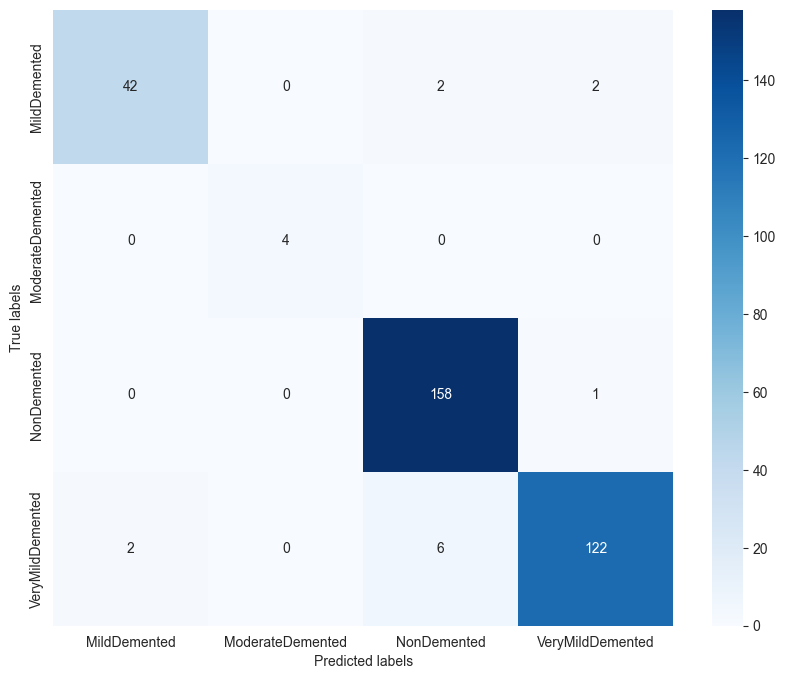

In [63]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, preds)

# Chuyển nhãn số thành tên loài hoa
label_names = le.inverse_transform(np.unique(y_test))
label_names = [label.split('/')[-1] for label in label_names]

# Sắp xếp lại ma trận nhầm lẫn
sorted_cm = cm[np.argsort(label_names)][:, np.argsort(label_names)]

# Tạo dataframe từ ma trận nhầm lẫn đã sắp xếp lại
df_cm = pd.DataFrame(sorted_cm, index=label_names, columns=label_names)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [60]:
import joblib

# Lưu mô hình tốt nhất đã đào tạo
joblib.dump(best_model, 'best_model_TransferLearning_LogisticRegression_Alzheimer.pkl')

# Để tải mô hình từ tệp đã lưu
loaded_model = joblib.load('best_model_TransferLearning_LogisticRegression_Alzheimer.pkl')


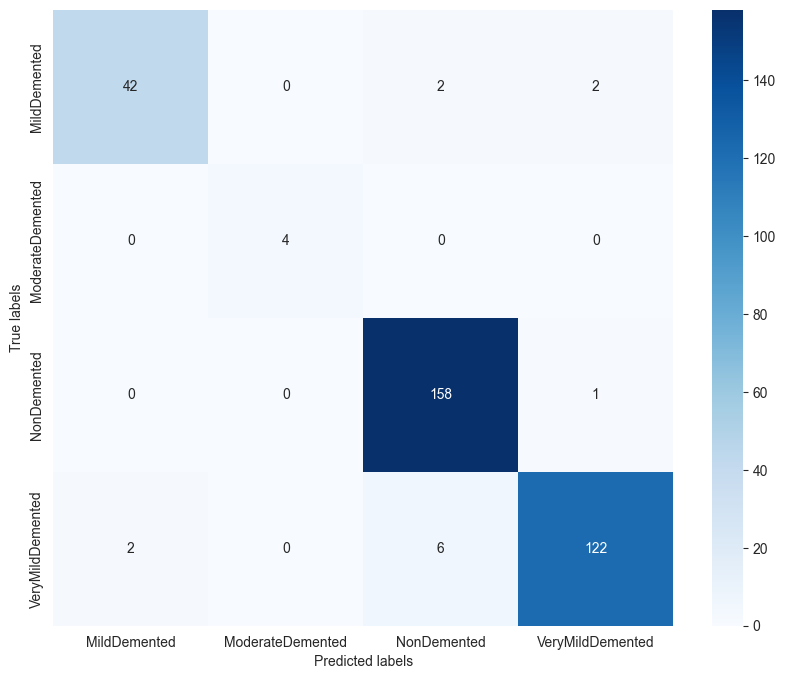

In [61]:
preds = loaded_model.predict(X_test) 
cm = confusion_matrix(y_test, preds)
label_names = le.inverse_transform(np.unique(y_test))
label_names = [label.split('/')[-1] for label in label_names]
sorted_cm = cm[np.argsort(label_names)][:, np.argsort(label_names)]
df_cm = pd.DataFrame(sorted_cm, index=label_names, columns=label_names)
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


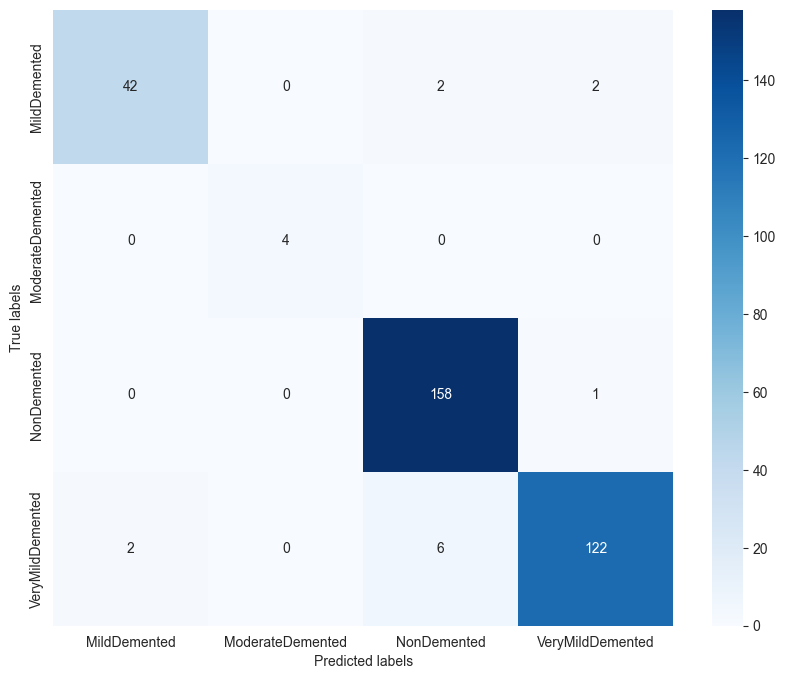